# Week 4 - NLP. Predicting real disasters based on text from Tweets

## Introduction
Problem Description
The task is to predict whether a tweet is about a real disaster or not. This is a binary classification problem where the output is a 1 (indicating the tweet is about a real disaster) or a 0 (indicating it is not).

Data Description:
- id: A unique identifier for each tweet.
- text: The text of the tweet.
- location: The location the tweet was sent from, which may be blank.
- keyword: A particular keyword from the tweet, which may also be blank.
- target: Only in train.csv. It denotes whether the tweet is about a real disaster (1) or not (0).

https://github.com/Lorviina/MastersofScienceDataScience

## Data Import

In [1]:
import pandas as pd

# Define the path to your files
base_path = r'C:\deep_learning\Scripts\data\Week4_NLP'

# Load the datasets
train_df = pd.read_csv(f'{base_path}\\train.csv')
test_df = pd.read_csv(f'{base_path}\\test.csv')
sample_submission_df = pd.read_csv(f'{base_path}\\sample_submission.csv')

# Display the first few rows of the training data
print(train_df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


## EDA

In [2]:
# Inspect data
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# Check for any null values
print("\nNull Values in Training Data:")
print(train_df.isnull().sum())
print("\nNull Values in Test Data:")
print(test_df.isnull().sum())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None

Null Values in Training Data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Null Values i

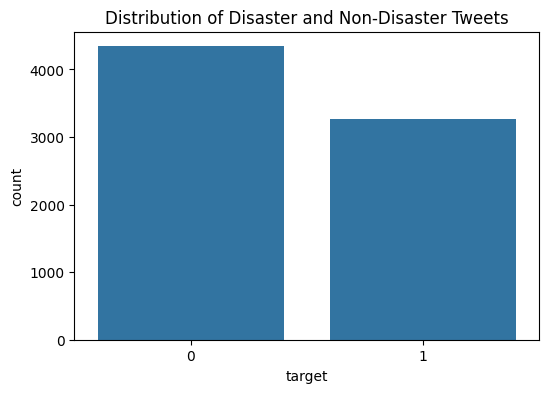

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster and Non-Disaster Tweets')
plt.show()

## Plan
My plan with this analysis is to use TF-IDF to process the texts to matrix form as I have used this method previously. I also wnat to include the keyword column for tokenizing, not just the 'text' column. To incorporate this into my modelling, I can use a concatenated column as the tokenized matrix.

Since we are to use an RNN family neural network, I am altering the process from TF-IDF to use a Tokenizer from keras.


## Preprocess the Data

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
# Replace NaN in 'keyword' with an empty string before concatenation
train_df['keyword'] = train_df['keyword'].fillna('')
test_df['keyword'] = test_df['keyword'].fillna('')

In [6]:
train_df['text_keyword'] = train_df['keyword'] + " " + train_df['text']
print(train_df.head())
test_df['text_keyword'] = test_df['keyword'] + " " + test_df['text']
print(test_df.head())

   id keyword location                                               text  \
0   1              NaN  Our Deeds are the Reason of this #earthquake M...   
1   4              NaN             Forest fire near La Ronge Sask. Canada   
2   5              NaN  All residents asked to 'shelter in place' are ...   
3   6              NaN  13,000 people receive #wildfires evacuation or...   
4   7              NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                       text_keyword  
0       1   Our Deeds are the Reason of this #earthquake ...  
1       1             Forest fire near La Ronge Sask. Canada  
2       1   All residents asked to 'shelter in place' are...  
3       1   13,000 people receive #wildfires evacuation o...  
4       1   Just got sent this photo from Ruby #Alaska as...  
   id keyword location                                               text  \
0   0              NaN                 Just happened a terrible car crash   
1   2

In [7]:
train_df['length'] = train_df['text_keyword'].apply(lambda x : len(x))
test_df['length'] = test_df['text_keyword'].apply(lambda x : len(x))

print("Train Length Stat")
print(train_df["length"].describe())
print()

print("Test Length Stat")
print(test_df["length"].describe())

Train Length Stat
count    7613.000000
mean      110.704584
std        34.492177
min         9.000000
25%        87.000000
50%       117.000000
75%       143.000000
max       164.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      111.951885
std        34.718777
min         9.000000
25%        88.000000
50%       120.000000
75%       143.000000
max       171.000000
Name: length, dtype: float64


## Specify the Global Variables & Build a Simple LSTM

In [8]:
BATCH_SIZE = 32
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
NUM_TRAINING_EXAMPLES = train_df.shape[0]
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE
EPOCHS = 5

In [9]:
# Split
X = train_df['text_keyword']
y = train_df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = VAL_SPLIT, random_state = 42)

X_test = test_df['text_keyword']

In [10]:
# Parameters for tokenization and padding
vocab_size = 1000  # Adjust based on your vocabulary size

# Find the maximum length in each dataframe
max_length_train = train_df['length'].max()
max_length_test = test_df['length'].max()

# Determine the overall maximum length across both dataframes
max_length = max(max_length_train, max_length_test) # Adjust based on the length of text

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [12]:
# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_shape=(max_length,)),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 171, 64)             │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,089 (379.25 KB)

 Trainable params: 97,089 (379.25 KB)

 Non-trainable params: 0 (0.00 B)

Why Define Input Shape? - Defining the input_shape helps TensorFlow allocate memory for the model's weights and prepare the computation graph. Without this, TensorFlow waits until it sees some data to complete building the model, which can lead to issues like what you're seeing in the summary output.

In [14]:
history = model.fit(X_train_pad, y_train, epochs=EPOCHS, validation_data=(X_val_pad, y_val), batch_size=BATCH_SIZE)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5671 - loss: 0.6857 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5700 - loss: 0.6841 - val_accuracy: 0.5739 - val_loss: 0.6828
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5689 - loss: 0.6842 - val_accuracy: 0.5739 - val_loss: 0.6832
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5724 - loss: 0.6832 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5712 - loss: 0.6835 - val_accuracy: 0.5739 - val_loss: 0.6824


In [15]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val_pad, y_val)
print(f'Validation Accuracy: {val_acc}')

# Predict on test data
predictions = model.predict(X_val_pad)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5694 - loss: 0.6835
Validation Accuracy: 0.5738673806190491
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [16]:
print("Length of y_val:", len(y_val))
print("Shape of predictions:", predictions.shape)

Length of y_val: 1523
Shape of predictions: (1523, 1)


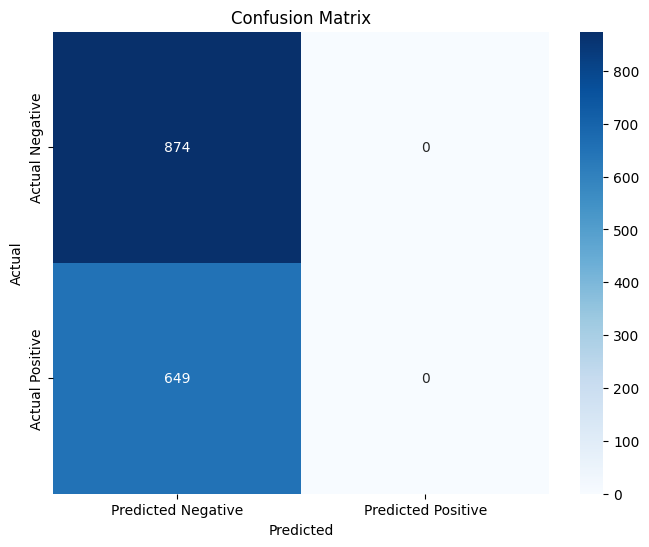

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Convert probabilities to binary predictions (0.5 threshold)
binary_predictions = np.where(predictions > 0.5, 1, 0)

# Generate the confusion matrix
cm = confusion_matrix(y_val, binary_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Hyperparameter Tuning

In [18]:
"""
Altering the optimizer from Adam to RMSProp
"""
from tensorflow.keras.optimizers import RMSprop
embedding_dim = 64
modelRMSProp= Sequential([
    Embedding(vocab_size, embedding_dim, input_shape=(max_length,)),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
modelRMSProp.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
modelRMSProp.summary()

C:\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 171, 64)             │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,089 (379.25 KB)

 Trainable params: 97,089 (379.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
historyRMSProp = modelRMSProp.fit(X_train_pad, y_train, epochs=EPOCHS, validation_data=(X_val_pad, y_val), batch_size=BATCH_SIZE)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.5718 - loss: 0.6848 - val_accuracy: 0.5739 - val_loss: 0.6830
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5657 - loss: 0.6851 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5712 - loss: 0.6837 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5668 - loss: 0.6849 - val_accuracy: 0.5739 - val_loss: 0.6835
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5656 - loss: 0.6850 - val_accuracy: 0.5739 - val_loss: 0.6822


In [20]:
"""
Altering Learning Rate & epochs & RMSprop & Larger embedding dim
EPOCHS = 15
"""
embedding_dim = 128
model3= Sequential([
    Embedding(vocab_size, embedding_dim, input_shape=(max_length,)),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model3.compile(optimizer=RMSprop(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 171, 128)            │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 177,473 (693.25 KB)

 Trainable params: 177,473 (693.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history3 = model3.fit(X_train_pad, y_train, epochs=15, validation_data=(X_val_pad, y_val), batch_size=BATCH_SIZE)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5555 - loss: 0.7085 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5690 - loss: 0.6846 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5610 - loss: 0.6864 - val_accuracy: 0.5739 - val_loss: 0.6848
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5868 - loss: 0.6806 - val_accuracy: 0.5739 - val_loss: 0.6844
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5736 - loss: 0.6830 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5765 - loss: 0.6817 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5626 - loss: 0.6854 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5607 - loss: 0.6866 - val_accu

In [22]:
"""
Altering Learning Rate & epochs & RMSprop & Larger embedding dim & Shape & BatchSize = 16
EPOCHS = 10
"""
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
embedding_dim = 128
model4= Sequential([
    Embedding(vocab_size, embedding_dim, input_shape=(max_length,)),
    LSTM(128, return_sequences = True),
    Dropout(0.2),
    LSTM(64, return_sequences = True),
    Dropout(0.2),
    LSTM(32, return_sequences = False),
    Dense(1, activation='sigmoid')
])
model4.compile(optimizer=RMSprop(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 171, 128)            │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 171, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 171, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 171, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 171, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 321,441 (1.23 MB)

 Trainable params: 321,441 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history4 = model4.fit(X_train_pad, y_train, epochs=10, validation_data=(X_val_pad, y_val), batch_size=32)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - accuracy: 0.5546 - loss: 0.7010 - val_accuracy: 0.5739 - val_loss: 0.6899
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.5794 - loss: 0.6839 - val_accuracy: 0.5739 - val_loss: 0.6833
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - accuracy: 0.5616 - loss: 0.6866 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.5700 - loss: 0.6840 - val_accuracy: 0.5739 - val_loss: 0.6834
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.5634 - loss: 0.6856 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - accuracy: 0.5665 - loss: 0.6850 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.5758 - loss: 0.6825 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.5684 - loss: 0

In [25]:
# Assuming you have the following imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X_val_pad, y_val):
    # Predictions
    y_pred_prob = model.predict(X_val_pad)  # This returns probabilities for Keras models
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
    
    # Ensure y_pred_prob is 2D for binary classification
    if y_pred_prob.ndim == 1:
        y_pred_prob = y_pred_prob.reshape(-1, 1)
    
    # For binary classification, we need the positive class probabilities
    if y_pred_prob.shape[1] == 2:
        y_pred_prob = y_pred_prob[:, 1]
    else:
        y_pred_prob = y_pred_prob.flatten()

    # Calculating metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    f1 = f1_score(y_val, y_pred, average='binary')
    auc = roc_auc_score(y_val, y_pred_prob)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc
    }

# Assume you've trained several models
results = {}
results['model'] = evaluate_model(model, X_val_pad, y_val)
results['modelRMSProp'] = evaluate_model(modelRMSProp, X_val_pad, y_val)
results['model3'] = evaluate_model(model3, X_val_pad, y_val)
results['model4'] = evaluate_model(model4, X_val_pad, y_val)

# Convert results to DataFrame
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 5/48 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
 1/48 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
              accuracy  precision  recall  f1_score  auc
model         0.573867        0.0     0.0       0.0  0.5
modelRMSProp  0.573867        0.0     0.0       0.0  0.5
model3        0.573867        0.0     0.0       0.0  0.5
model4        0.573867        0.0     0.0       0.0  0.5


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## ALERT/ISSUE
I seem to have an issue with my method using tokenization.

**Attempt to make a better model using TF-IDF**

In [26]:
# Create and fit the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Convert to dense arrays for Keras
X_train_tfidf = X_train_tfidf.toarray()
X_val_tfidf = X_val_tfidf.toarray()

In [29]:
"""
Altering Learning Rate & epochs & RMSprop & Larger embedding dim & Shape & BatchSize = 16
EPOCHS = 10
"""
input_dim = X_train_tfidf.shape[1]
model_tf = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_tf.compile(optimizer = RMSprop(learning_rate=0.001), loss = 'binary_crossentropy', 
                 metrics=['accuracy'])


In [30]:
model_tf.fit(X_train_tfidf, y_train, epochs=10, batch_size=16, 
             validation_data=(X_val_tfidf, y_val), verbose=1)


Epoch 1/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5881 - loss: 0.6689 - val_accuracy: 0.7794 - val_loss: 0.5235
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7894 - loss: 0.4887 - val_accuracy: 0.7932 - val_loss: 0.4686
Epoch 3/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8339 - loss: 0.4055 - val_accuracy: 0.7932 - val_loss: 0.4736
Epoch 4/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8524 - loss: 0.3715 - val_accuracy: 0.7978 - val_loss: 0.4671
Epoch 5/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8573 - loss: 0.3628 - val_accuracy: 0.8004 - val_loss: 0.4801
Epoch 6/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8673 - loss: 0.3464 - val_accuracy: 0.8017 - val_loss: 0.4887
Epoch 7/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8722 - loss: 0.3436 - val_accuracy: 0.7984 - val_loss: 0.5073
Epoch 8/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8740 - loss: 0.3364 - val_accuracy: 0.

In [31]:
# Evaluation function
def evaluate_model(model, X_val_tfidf, y_val):
    y_pred_prob = model.predict(X_val_tfidf)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='binary', zero_division=1)
    recall = recall_score(y_val, y_pred, average='binary', zero_division=1)
    f1 = f1_score(y_val, y_pred, average='binary', zero_division=1)
    auc = roc_auc_score(y_val, y_pred_prob)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc
    }

In [34]:
results_tf = evaluate_model(model_tf, X_val_tfidf, y_val)
print(results_tf)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
{'accuracy': 0.7971109652002626, 'precision': 0.7786885245901639, 'recall': 0.7318952234206472, 'f1_score': 0.7545671167593329, 'auc': 0.8510620105566389}


The provided code below demonstrates the use of Keras Tuner (kt.Hyperband) to optimize hyperparameters for a neural network model designed for binary classification. The build_model function defines the model architecture and specifies which hyperparameters to tune. Within this function, the number of units in the first dense layer, the dropout rate, and the number of additional dense layers (including their units) are dynamically set based on values provided by the hyperparameter tuner. The learning rate and the optimizer type (either Adam or RMSprop) are also selected from predefined options. Each configuration of hyperparameters is then compiled into a model, ready for training.

The process of hyperparameter tuning is conducted through the Hyperband algorithm, a variant of random search that uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model configuration. The tuner searches over defined hyperparameter space using the training data (X_train_tfidf, y_train) and validation data (X_val_tfidf, y_val) for a maximum of 50 epochs, but can stop earlier if no improvement in validation loss is observed for 5 epochs consecutively (as governed by the EarlyStopping callback). After the search, the best hyperparameters are extracted, and a final model is built using these optimal values. This model is then trained again, and its performance is evaluated on the same training and validation datasets, potentially achieving better accuracy due to the optimized hyperparameters.

In [35]:
def build_model(hp):
    model = Sequential()
    
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu', input_shape=(input_dim,)))
    
    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout))
    
    # Tune the number of dense layers and their units
    for i in range(hp.Int('num_layers', 1, 4)):
        hp_units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        model.add(Dense(units=hp_units, activation='relu'))
        model.add(Dropout(hp_dropout))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Tune the optimizer
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    else:
        optimizer = RMSprop(learning_rate=hp_learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
import keras_tuner as kt

In [40]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='keras_tuner_project')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train_tfidf, y_train,
             epochs=50,
             validation_data=(X_val_tfidf, y_val),
             callbacks=[stop_early])

Trial 30 Complete [00h 00m 06s]
val_accuracy: 0.8010505437850952

Best val_accuracy So Far: 0.8089297413825989
Total elapsed time: 00h 01m 49s


In [41]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_tfidf, y_train,
                    epochs=50,
                    validation_data=(X_val_tfidf, y_val),
                    callbacks=[stop_early])


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.01.

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6860 - loss: 0.5866 - val_accuracy: 0.7978 - val_loss: 0.4512
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8536 - loss: 0.3529 - val_accuracy: 0.8017 - val_loss: 0.4853
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8928 - loss: 0.2673 - val_accuracy: 0.8024 - val_loss: 0.4752
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9273 - loss: 0.1988 - val_accuracy: 0.7984 - val_loss: 0.6855
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9539 - loss: 0.1294 - val_accuracy: 0.7859 - val_loss: 0.7089
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9664 - loss: 0.0967 - val_accuracy: 0.7919 - val_loss: 0.9234


In [42]:
best_model = tuner.get_best_models(num_models=1)[0]
results_best = evaluate_model(best_model, X_val_tfidf, y_val)
print("Results of the best model:")
print(results_best)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Results of the best model:
{'accuracy': 0.8089297439264609, 'precision': 0.842911877394636, 'recall': 0.6779661016949152, 'f1_score': 0.7514944491887275, 'auc': 0.8560829369598714}


My idea with the below is to design an experimental space to systematically explore the hyperparameter space to find an optimal parameter search. We define the space, use a function to build and evaluate the models, implement grid search, use a random search for fine-tuning the space, and then analyse the results using heat maps. 

We can then see how different combinations affect the model's performance. The scatter plots from the fine-tuning stage will show if there are any clear trends or optimal regions. Which is extremely interesting becuase this may highlight to us that no matter the hyperparameter tuning we can only get max(X) score with this method. 

I have used JMP to create a Designed Experiment for the following parameters:

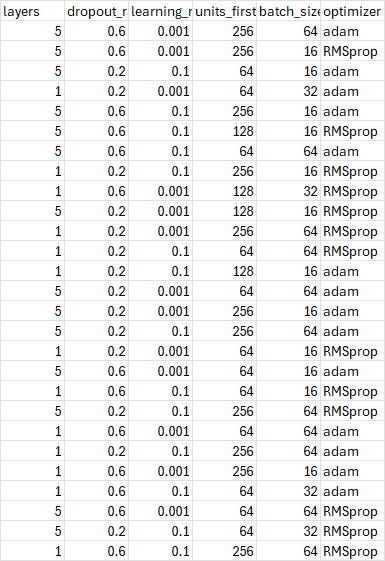

In [55]:
def build_and_train_model(X_train, y_train, X_val, y_val, params):
    model = Sequential()
    model.add(Dense(params['units_first_layer'], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(params['dropout_rate']))
    
    for _ in range(params['layers'] - 1):
        model.add(Dense(params['units_first_layer'], activation='relu'))
        model.add(Dropout(params['dropout_rate']))
    
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    model.compile(optimizer=params['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=params['batch_size'], validation_data=(X_val, y_val))
    
    return history

In [56]:
# Create a dictionary of the DoE to then pass to the model building
experiment_parameters = [
    {'layers': 5, 'dropout_rate': 0.6, 'learning_rate': 0.001, 'units_first_layer': 256, 'batch_size': 64, 'optimizer': 'adam'},
    {'layers': 5, 'dropout_rate': 0.6, 'learning_rate': 0.001, 'units_first_layer': 256, 'batch_size': 16, 'optimizer': 'RMSprop'},
    {'layers': 5, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'units_first_layer': 64, 'batch_size': 16, 'optimizer': 'adam'},
    {'layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units_first_layer': 64, 'batch_size': 32, 'optimizer': 'adam'},
    {'layers': 5, 'dropout_rate': 0.6, 'learning_rate': 0.1, 'units_first_layer': 256, 'batch_size': 16, 'optimizer': 'adam'},
    {'layers': 5, 'dropout_rate': 0.6, 'learning_rate': 0.1, 'units_first_layer': 128, 'batch_size': 16, 'optimizer': 'RMSprop'},
    {'layers': 5, 'dropout_rate': 0.6, 'learning_rate': 0.1, 'units_first_layer': 64, 'batch_size': 64, 'optimizer': 'adam'},
    {'layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'units_first_layer': 256, 'batch_size': 16, 'optimizer': 'RMSprop'},
    {'layers': 1, 'dropout_rate': 0.6, 'learning_rate': 0.001, 'units_first_layer': 128, 'batch_size': 32, 'optimizer': 'RMSprop'},
    {'layers': 5, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units_first_layer': 128, 'batch_size': 16, 'optimizer': 'RMSprop'},
    {'layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units_first_layer': 256, 'batch_size': 64, 'optimizer': 'RMSprop'},
    {'layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'units_first_layer': 64, 'batch_size': 64, 'optimizer': 'RMSprop'},
    {'layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'units_first_layer': 128, 'batch_size': 16, 'optimizer': 'adam'},
    {'layers': 5, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units_first_layer': 64, 'batch_size': 64, 'optimizer': 'adam'},
    {'layers': 5, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units_first_layer': 256, 'batch_size': 16, 'optimizer': 'adam'},
    {'layers': 5, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'units_first_layer': 256, 'batch_size': 64, 'optimizer': 'adam'},
    {'layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units_first_layer': 64, 'batch_size': 16, 'optimizer': 'RMSprop'},
    {'layers': 5, 'dropout_rate': 0.6, 'learning_rate': 0.001, 'units_first_layer': 64, 'batch_size': 16, 'optimizer': 'adam'},
    {'layers': 1, 'dropout_rate': 0.6, 'learning_rate': 0.1, 'units_first_layer': 64, 'batch_size': 16, 'optimizer': 'RMSprop'},
    {'layers': 5, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'units_first_layer': 256, 'batch_size': 64, 'optimizer': 'RMSprop'},
    {'layers': 1, 'dropout_rate': 0.6, 'learning_rate': 0.001, 'units_first_layer': 64, 'batch_size': 64, 'optimizer': 'adam'},
    {'layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'units_first_layer': 256, 'batch_size': 64, 'optimizer': 'adam'},
    {'layers': 1, 'dropout_rate': 0.6, 'learning_rate': 0.001, 'units_first_layer': 256, 'batch_size': 16, 'optimizer': 'adam'},
    {'layers': 1, 'dropout_rate': 0.6, 'learning_rate': 0.1, 'units_first_layer': 64, 'batch_size': 32, 'optimizer': 'adam'},
    {'layers': 5, 'dropout_rate': 0.6, 'learning_rate': 0.001, 'units_first_layer': 64, 'batch_size': 64, 'optimizer': 'RMSprop'},
    {'layers': 5, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'units_first_layer': 64, 'batch_size': 32, 'optimizer': 'RMSprop'},
    {'layers': 1, 'dropout_rate': 0.6, 'learning_rate': 0.1, 'units_first_layer': 256, 'batch_size': 64, 'optimizer': 'RMSprop'}
]

In [57]:
results = []

for params in experiment_parameters:
    try:
        model_history = build_and_train_model(X_train_tfidf, y_train, X_val_tfidf, y_val, params)
        # Assuming you want to capture final validation accuracy and loss
        final_val_accuracy = model_history.history['val_accuracy'][-1]
        final_val_loss = model_history.history['val_loss'][-1]
        results.append({**params, 'val_accuracy': final_val_accuracy, 'val_loss': final_val_loss})
    except Exception as e:
        print(f"Failed to train model with parameters {params}: {str(e)}")

results_df = pd.DataFrame(results)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5666 - loss: 0.6821 - val_accuracy: 0.6921 - val_loss: 0.5992
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7493 - loss: 0.5382 - val_accuracy: 0.8024 - val_loss: 0.4668
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8563 - loss: 0.3677 - val_accuracy: 0.7971 - val_loss: 0.4868
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9023 - loss: 0.2696 - val_accuracy: 0.8004 - val_loss: 0.5398
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9242 - loss: 0.1992 - val_accuracy: 0.7820 - val_loss: 0.5962
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9407 - loss: 0.1730 - val_accuracy: 0.7741 - val_loss: 0.6527
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9535 - loss: 0.1224 - val_accuracy: 0.7689 - val_loss: 0.8437
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9662 - loss: 0.1089 - val_accuracy: 0.7590 - val_loss:

In [64]:
results_df['index'] = results_df.index
print(results_df.head())

   layers  dropout_rate  learning_rate  units_first_layer  batch_size  \
0       5           0.6          0.001                256          64   
1       5           0.6          0.001                256          16   
2       5           0.2          0.100                 64          16   
3       1           0.2          0.001                 64          32   
4       5           0.6          0.100                256          16   

  optimizer  val_accuracy  val_loss  index  
0      adam      0.771504  0.889323      0  
1   RMSprop      0.795798  0.644275      1  
2      adam      0.775443  1.769610      2  
3      adam      0.764281  0.635674      3  
4      adam      0.764281  0.873104      4  


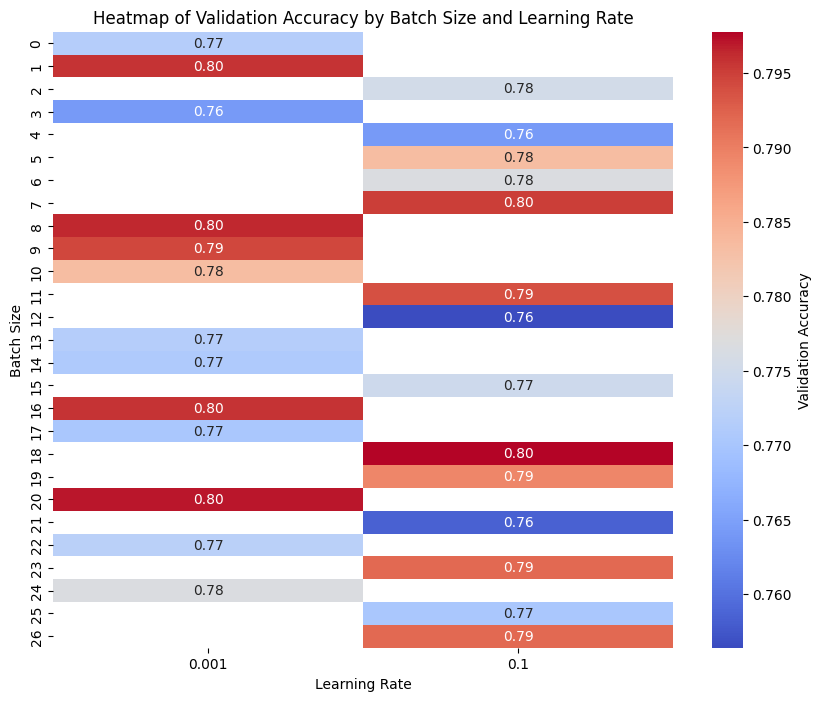

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correcting the pivot call
heatmap_data = results_df.pivot(index='index', columns='learning_rate', values='val_accuracy')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Validation Accuracy'})
plt.title('Heatmap of Validation Accuracy by Batch Size and Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Batch Size')
plt.show()

# Conclusion
With the TF_IDF method I have been able to achieve a much better val_accuracy score than before using tokenization. I will probably have to go back and look at the tokenization steps to make sure I have implemented it correctly. Even using a designed experiment for the TF-IDF implementation, with the hyperparameter space limits I have chosen, it does not seem possbile to achieve a greater val_accuracy than roughly 0.8. 

In the future, I want to try larger Sequential models utilizing TF-IDF as well as redoing the tokenization in my first section. I also want to try fine-tuning on the hyperparameter space/explore a greater design space. 

In [71]:
# Use best_model to predict 'test'
X_test_tfidf = tfidf_vectorizer.transform(X_test)
predictions = model.predict(X_test_tfidf)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [73]:
predicted_labels = (predictions > 0.5).astype(int)
predicted_labels_list = predicted_labels.flatten().tolist()

In [76]:
print(test_df.head())

   id keyword location                                               text  \
0   0              NaN                 Just happened a terrible car crash   
1   2              NaN  Heard about #earthquake is different cities, s...   
2   3              NaN  there is a forest fire at spot pond, geese are...   
3   9              NaN           Apocalypse lighting. #Spokane #wildfires   
4  11              NaN      Typhoon Soudelor kills 28 in China and Taiwan   

                                        text_keyword  length  
0                 Just happened a terrible car crash      35  
1   Heard about #earthquake is different cities, ...      65  
2   there is a forest fire at spot pond, geese ar...      97  
3           Apocalypse lighting. #Spokane #wildfires      41  
4      Typhoon Soudelor kills 28 in China and Taiwan      46  


In [89]:
# Create a DataFrame with the original test data and the predicted labels.
results_df = pd.DataFrame({
    'id': test_df['id'], 
    'target': predicted_labels_list
})
print(results_df.head())

   id  target
0   0       0
1   2       0
2   3       1
3   9       1
4  11       1


In [90]:
results_df.to_csv('C:\deep_learning\Scripts\data\Week4_NLP\Tweet Disaster Prediction Results.csv', index=False)

In [91]:
len(results_df)

3263

In [92]:
# Assuming 'id' is a column in your results_df DataFrame
unique_ids = results_df['id'].unique()

# Count the unique IDs
number_of_unique_ids = len(unique_ids)

# Print the count of unique IDs
print("Number of unique IDs:", number_of_unique_ids)

Number of unique IDs: 3263


# Kaggle Score
0.78057 